# Explore_features_ML_NLP

Author: Nicolai Wolpert  
Email: nicolai.wolpert@capgemini.com  
October 2024

Ce notebook utilise le meilleur modèle d'apprentissage automatique pour prédire l'endométriose et explore l'impact des différentes features/symptômes des patientes sur la classification. L'objectif est d'avoir le moins de symptômes possible tout en obtenant la meilleure prédiction possible.
Car ces symptômes devront être prédits en utilisant du NLP, et pour cela, moins il y a de symptômes, plus cela est facile.

In [1]:
# Imports :

import numpy as np
import pandas as pd
import string 
import pickle

# Plot : 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

from sklearn.model_selection import train_test_split, GridSearchCV
from skopt import BayesSearchCV

# Utils for encoding : 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

# Utils for regression : 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, make_scorer

# Utils for classification :
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier, plot_importance
from sklearn.ensemble import HistGradientBoostingClassifier

# Utils for Metrics calculation : 
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve
from metrics_utils import rewrite_keys, rapport_metrics_decision_tree
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

# Custom utils  
from Opti_utils.ML_utils import find_best_threshold, from_model_to_bst_trhld, custom_metrics, scores, compare_results,find_error
from Opti_utils.ML_utils import FP, TP, FN, TN, check_corr_col, filtre_list, fit_method, check_baseline, check_FP_FN, check_best_results
from Opti_utils.ML_utils import ML_opti_recueil, univariate_ml, sensi, speci, mix_sensi_speci, custom_metric
from Opti_utils.ML_utils import Binarisation, model_to_plot, clean_lists

# Ouverture des datas : 

In [3]:
recueil_imc  = pd.read_excel('Data/DATA_RAW/Recueil (1).xlsx').drop('Unnamed: 90', axis=1)
recueil_imc.shape

(181, 90)

In [4]:
# On enlève les colonnes liés a la chirurgie : 
liste_colonnes_chir = ['date.chir', 'chir.macro.lusd', 'chir.macro.lusg', 'chir.macro.torus',  'chir.macro.oma', 'chir.macro.uro', 'chir.macro.dig',  'chir.macro.superf', 'resec.lusd', 'resec.lusg', 'resec.torus', 'resec.autre']
for col_to_drop in liste_colonnes_chir:
    recueil_imc = recueil_imc.drop(col_to_drop, axis=1)
# Remplace les manquantes par un np.nan
recueil_imc.replace(['Na', 'NA', 'nan', 'Nan', 'NAN'], np.nan, inplace=True)
# n_ano en Index
recueil_imc = recueil_imc.set_index('Numéro anonymat')
recueil_imc.shape

/tmp/ipykernel_13910/2947652957.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  recueil_imc.replace(['Na', 'NA', 'nan', 'Nan', 'NAN'], np.nan, inplace=True)


(181, 77)

# Préparation pour le ML : 

## Split des features et des targets : 

In [5]:
# recueil_imc.dropna(axis=0, inplace=True)
target = recueil_imc.iloc[:,-4:].copy()
features = recueil_imc.iloc[:,:-4].copy()

endometriose = target.loc[:,['anapath.lusd','anapath.lusg','anapath.torus']].sum(axis=1).apply(lambda x: Binarisation(x))

recueil_imc_endo = recueil_imc.copy()
recueil_imc_endo['endometriose'] = endometriose
recueil_imc_endo.shape

(181, 78)

In [6]:
# Voici les colonnes qui ne sont pas disponible pour le NLP normalement
features_to_drop_for_nlp = ['age', 'imc', 'g', 'p', 'sf.dsp.eva', 'sf.dsm.eva']

## Préparation des données : 

In [7]:
features_chir_ONE = pd.get_dummies(features.loc[:,'chir'], prefix='chir')
features_dsptype_ONE = pd.get_dummies(features.loc[:,'sf.dsp.type'].replace(0, 'aucun'), prefix='dsp.type')
features_enc = pd.concat([features.drop('chir', axis=1).drop('sf.dsp.type', axis=1), features_chir_ONE, features_dsptype_ONE], axis=1)

In [8]:
features_enc

,age,imc,g,p,atcd.endo,atcd.chir.oma,atcd.fibrome,atcd.chir.endo,atcd.infertilite,atcd.pma,...,chir_SU,chir_SW,dsp.type_aucun,dsp.type_orificielle,dsp.type_positionnelle,dsp.type_post coïtale,dsp.type_profonde,dsp.type_profonde et orificielle,dsp.type_profonde positionnelle,dsp.type_profonde post coïtale
Numéro anonymat,,,,,,,,,,,,,,,,,,,,,
NJ-001,39,20.7,0,0,0,0,0,0,1,1,...,False,False,False,False,False,False,True,False,False,False
JJ-002,36,21.6,5,3,0,0,0,0,0,0,...,False,True,False,False,False,False,True,False,False,False
LA-003,41,32.5,1,0,0,0,0,0,1,1,...,False,True,True,False,False,False,False,False,False,False
DS-004,27,15.9,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
BM-005,37,22.9,1,0,1,0,0,1,0,0,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WL-197,37,23.4,1,1,1,1,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
TC-198,27,35.8,2,1,0,0,0,0,0,0,...,False,True,False,False,False,False,True,False,False,False
BD-200,44,26.0,1,1,1,1,0,1,1,1,...,False,False,True,False,False,False,False,False,False,False


In [9]:
# split 
X_train, X_test, y_train, y_test = train_test_split(features_enc, endometriose, random_state=42, stratify=endometriose)

In [10]:
features_enc

,age,imc,g,p,atcd.endo,atcd.chir.oma,atcd.fibrome,atcd.chir.endo,atcd.infertilite,atcd.pma,...,chir_SU,chir_SW,dsp.type_aucun,dsp.type_orificielle,dsp.type_positionnelle,dsp.type_post coïtale,dsp.type_profonde,dsp.type_profonde et orificielle,dsp.type_profonde positionnelle,dsp.type_profonde post coïtale
Numéro anonymat,,,,,,,,,,,,,,,,,,,,,
NJ-001,39,20.7,0,0,0,0,0,0,1,1,...,False,False,False,False,False,False,True,False,False,False
JJ-002,36,21.6,5,3,0,0,0,0,0,0,...,False,True,False,False,False,False,True,False,False,False
LA-003,41,32.5,1,0,0,0,0,0,1,1,...,False,True,True,False,False,False,False,False,False,False
DS-004,27,15.9,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
BM-005,37,22.9,1,0,1,0,0,1,0,0,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WL-197,37,23.4,1,1,1,1,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
TC-198,27,35.8,2,1,0,0,0,0,0,0,...,False,True,False,False,False,False,True,False,False,False
BD-200,44,26.0,1,1,1,1,0,1,1,1,...,False,False,True,False,False,False,False,False,False,False


In [11]:
scorer = make_scorer(custom_metric, greater_is_better=True)
mix_recall = make_scorer(mix_sensi_speci, greater_is_better=True)
sensibilite = make_scorer(sensi, greater_is_better=True)
specificite = make_scorer(speci, greater_is_better=True)
scorers = { 'speci': specificite, 'sensi' : sensibilite}

## Résultats : 

In [14]:
with open('Data/DATA_PROCESSED/data.pkl', 'rb') as f1:
    dictionnary_list = pickle.load(f1)
    
liste_col_speci= dictionnary_list['specifite']
liste_col_sensi = dictionnary_list['sensibilite']
liste_col_mixte = dictionnary_list['moyenne']

In [15]:
liste_col_speci

['age',
 'imc',
 'p',
 'atcd.chir.oma',
 'atcd.fibrome',
 'atcd.chir.endo',
 'atcd.pma',
 'atcd.fiv',
 'desir.G',
 'atcd.sma.douleur',
 'atcd.hospit.douleur',
 'atcd.absenteisme',
 'ttt.op',
 'ttt.p',
 'ttt.ains',
 'ttt.p1',
 'ttt.p2',
 'ttt.p3',
 'sf.dsm.type',
 'sf.dsm.eva',
 'sf.dpc',
 'sf.dsp.eva',
 'sf.dig.diarrhee',
 'sf.dig.constip',
 'sf.dig.rectorragie',
 'sf.uro',
 'sf.scap',
 'sf.ombilic',
 'ef.hormone.dsp',
 'ef.hormone.dsm',
 'ef.hormone.dpc',
 'effet.hormone.dig',
 'tv.douloureux',
 'tv.douleur.lusd',
 'tv.douleur.lusg',
 'tv.douleur.torus',
 'tv.nodule.lusd',
 'tv.nodule.lusg',
 'tv.nodule.torus',
 'spec.nodule',
 'echo.adm',
 'echo.noduleRV',
 'echo.lusd',
 'echo.lusg',
 'echo.torus',
 'echo.rectum',
 'echo.sigmoide',
 'irm.endo',
 'irm.adm',
 'irm.lusd',
 'irm.lusg',
 'irm.torus',
 'irm.oma',
 'irm.dig',
 'irm.vagin',
 'irm.kissing',
 'irm.adherences',
 'irm.retroversion',
 'irm.epanchement',
 'irm.opac.vagin',
 'irm.opac.rectum',
 'irm.externe',
 'avis.dig/uro',
 'chi

In [16]:
liste_col_sensi = clean_lists(liste_col_sensi)
liste_col_speci = clean_lists(liste_col_speci)
liste_col_mixte = clean_lists(liste_col_mixte)

# Essais de ML avec les colonnes :

In [17]:
seed = 42 

In [18]:
## Init Metrics :
scorer = make_scorer(custom_metric, greater_is_better=True)
mix_recall = make_scorer(mix_sensi_speci, greater_is_better=True)
sensibilite = make_scorer(sensi, greater_is_better=True)
specificite = make_scorer(speci, greater_is_better=True)

In [19]:
# Params :
param1 = {'min_child_weight': [1, 5, 10],
 'gamma': [0, 0.5, 1, 1.5, 2, 5],
 'subsample': [0.6, 0.8, 1.0],
 'colsample_bytree': [0.6, 0.8, 1.0],
 'max_depth': [3, 4, 5, 6, 7, 8],
 'n_estimators': [50, 100, 150, 200, 300, 500]}

## ML : 

In [20]:
# On enlève les colonnes correlées : 
X_train_ = X_train.copy()
X_test_ = X_test.copy()

liste_to_drop = ['p','atcd.chir.endo','atcd.infertilite','sf.dsm','sf.dsp','ef.hormone.dsm','echo.oma','irm.xr']
for col in liste_to_drop:
    X_test_.drop(col, axis=1, inplace=True)
    X_train_.drop(col, axis=1, inplace=True)

In [21]:
tree_1 = XGBClassifier(random_state=seed)
test_cv = cross_validate(tree_1, X_train_, y_train, cv=5, scoring=scorers, return_estimator =True)

print('sensi : ',round(test_cv['test_sensi'].mean(), 2))
print('speci : ',round(test_cv['test_speci'].mean(),2))

sensi :  0.61
speci :  0.48


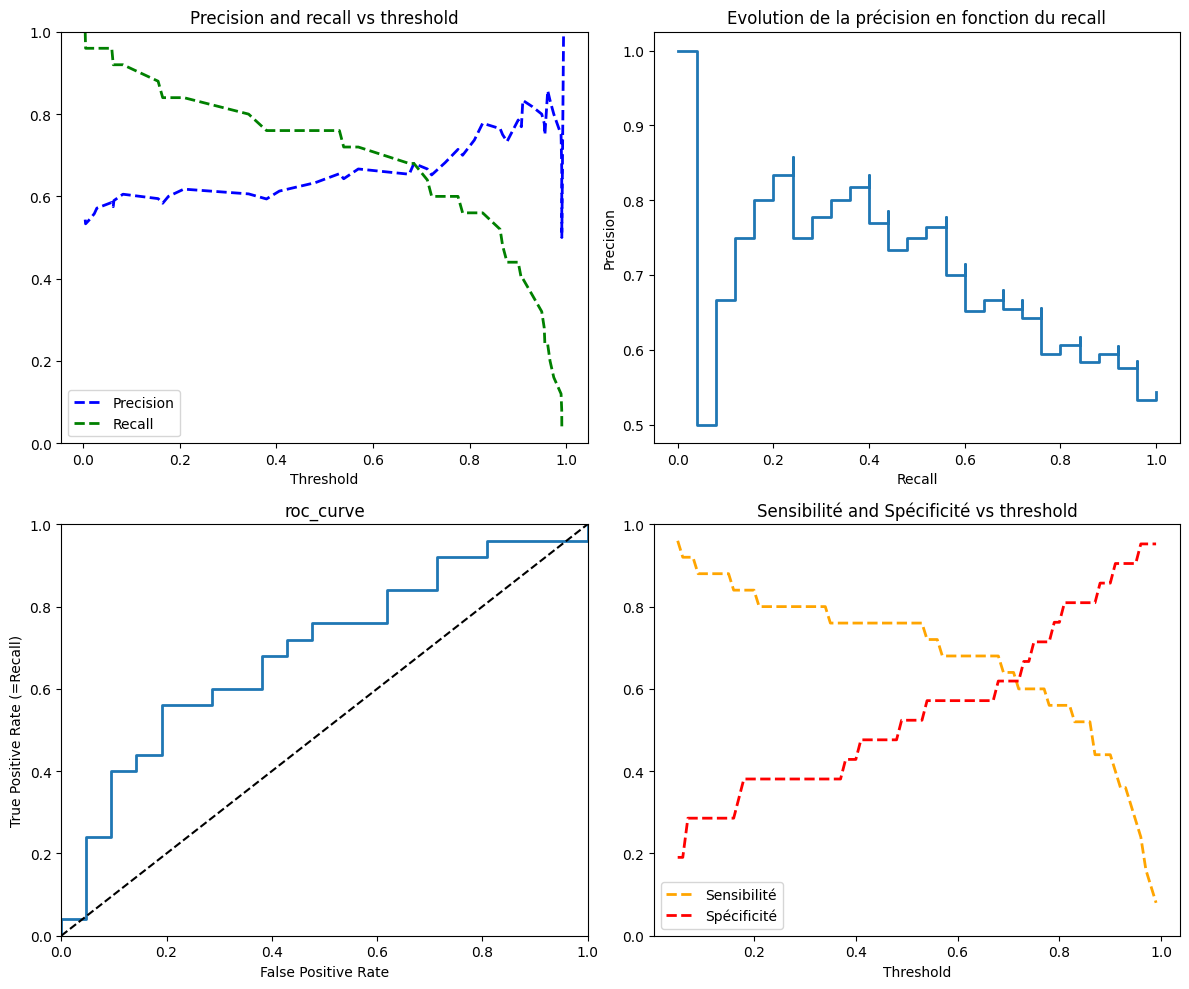

threshold = 0,5
Sensibilité :  0.76
Spécificité :  0.5238095238095238
_________________________________________________________
Best threshold : 0.81
Sensibilité : 0.56
Spécificité : 0.8095238095238095


In [22]:
tree_BL = XGBClassifier(random_state=seed, )
tree_BL.fit(X_train_, y_train)
pred_BL = tree_BL.predict(X_test_)
model_to_plot(tree_BL, X_test_, y_test)
resultat_BL = pd.DataFrame(pd.Series(scores(y_test, pred_BL)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_BL.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_BL.loc['specificité','XGB_BL_sensi'])
dict_ = from_model_to_bst_trhld(tree_BL, X_test_, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_['best_threshold'])
print('Sensibilité :', dict_['scores']['sensibilite'])
print('Spécificité :', dict_['scores']['specificité'])

                feature  importance
0                  age        55.0
1                  imc        49.0
15          sf.dsp.eva        36.0
13          sf.dsm.eva        29.0
2                    g        27.0
3            atcd.endo        23.0
42            irm.lusg        22.0
25       tv.douloureux        18.0
16     sf.dig.diarrhee        16.0
48         irm.externe        16.0
23      ef.hormone.dpc        15.0
35           echo.lusd        15.0
36           echo.lusg        15.0
21       effet.hormone        14.0
9     atcd.absenteisme        13.0
26     tv.douleur.lusd        12.0
8     atcd.sma.douleur        11.0
33            echo.adm        11.0
7              desir.G        10.0
46    irm.retroversion        10.0
49            chir_CAP        10.0
37          echo.torus         9.0
47     irm.opac.rectum         9.0
18  sf.dig.rectorragie         9.0
17      sf.dig.constip         7.0
19              sf.uro         7.0
30      tv.nodule.lusg         6.0
10               tt

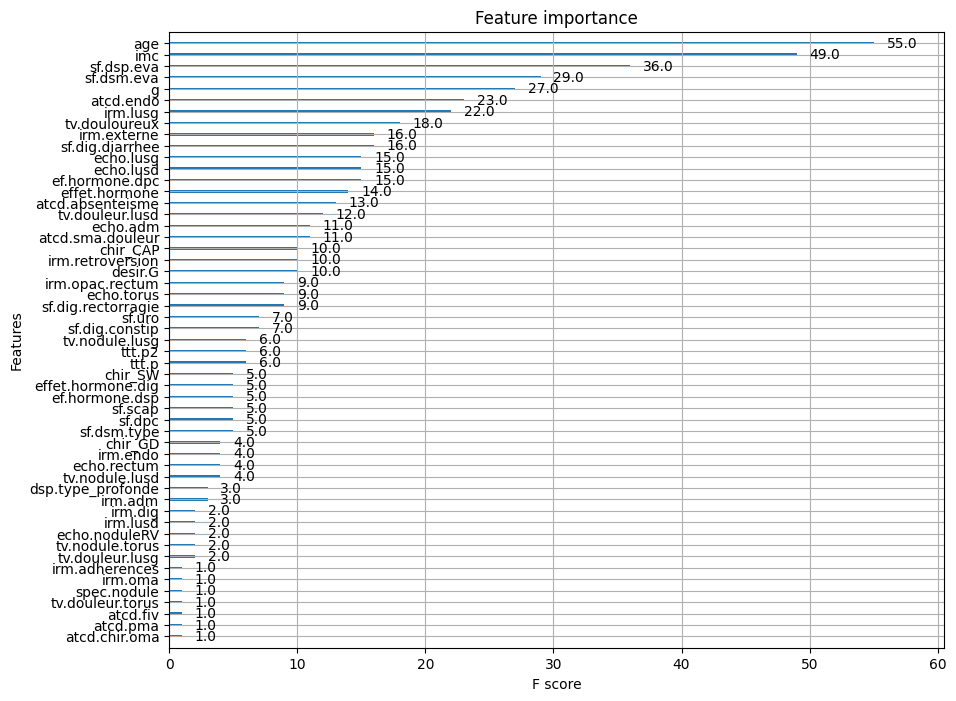

In [23]:
# Show feature importance
xgb_fea_imp=pd.DataFrame(list(tree_BL.get_booster().get_fscore().items()),
columns=['feature','importance']).sort_values('importance', ascending=False)
print('',xgb_fea_imp)
xgb_fea_imp.to_csv('xgb_fea_imp.csv')

ax = plot_importance(tree_BL, )
ax.figure.set_size_inches(10,8)

                feature  importance
0                  age        55.0
1                  imc        49.0
15          sf.dsp.eva        36.0
13          sf.dsm.eva        29.0
2                    g        27.0
3            atcd.endo        23.0
42            irm.lusg        22.0
25       tv.douloureux        18.0
16     sf.dig.diarrhee        16.0
48         irm.externe        16.0
23      ef.hormone.dpc        15.0
35           echo.lusd        15.0
36           echo.lusg        15.0
21       effet.hormone        14.0
9     atcd.absenteisme        13.0
26     tv.douleur.lusd        12.0
8     atcd.sma.douleur        11.0
33            echo.adm        11.0
7              desir.G        10.0
46    irm.retroversion        10.0
49            chir_CAP        10.0
37          echo.torus         9.0
47     irm.opac.rectum         9.0
18  sf.dig.rectorragie         9.0
17      sf.dig.constip         7.0
19              sf.uro         7.0
30      tv.nodule.lusg         6.0
10               tt

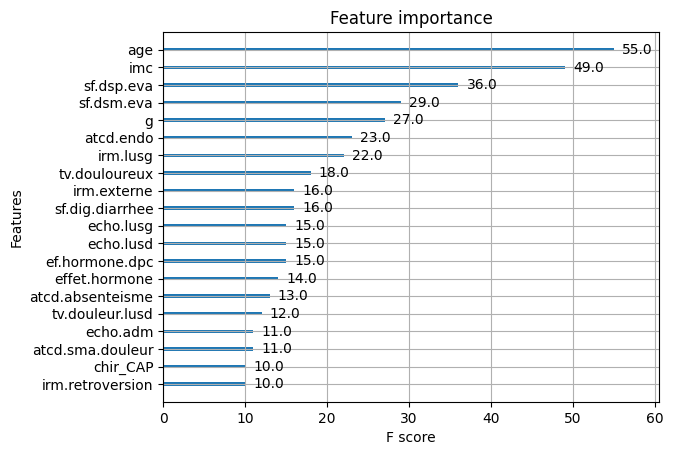

In [24]:
# Show feature importance
xgb_fea_imp=pd.DataFrame(list(tree_BL.get_booster().get_fscore().items()),
columns=['feature','importance']).sort_values('importance', ascending=False)
print('',xgb_fea_imp)
ax = plot_importance(tree_BL, max_num_features=20)

--> Infos démographique + évaluations sont les plus importants pour pouvoir prédire l'endométriose

In [25]:
features_to_drop_for_nlp

['age', 'imc', 'g', 'p', 'sf.dsp.eva', 'sf.dsm.eva']

### Encore des bonnes performances si on enlève les colonnes pas disponible pour la partie NLP?

In [28]:
X_train_nlp_features = X_train.copy()
X_test_nlp_features = X_test.copy()

for col in features_to_drop_for_nlp:
    X_test_nlp_features.drop(col, axis=1, inplace=True)
    X_train_nlp_features.drop(col, axis=1, inplace=True)

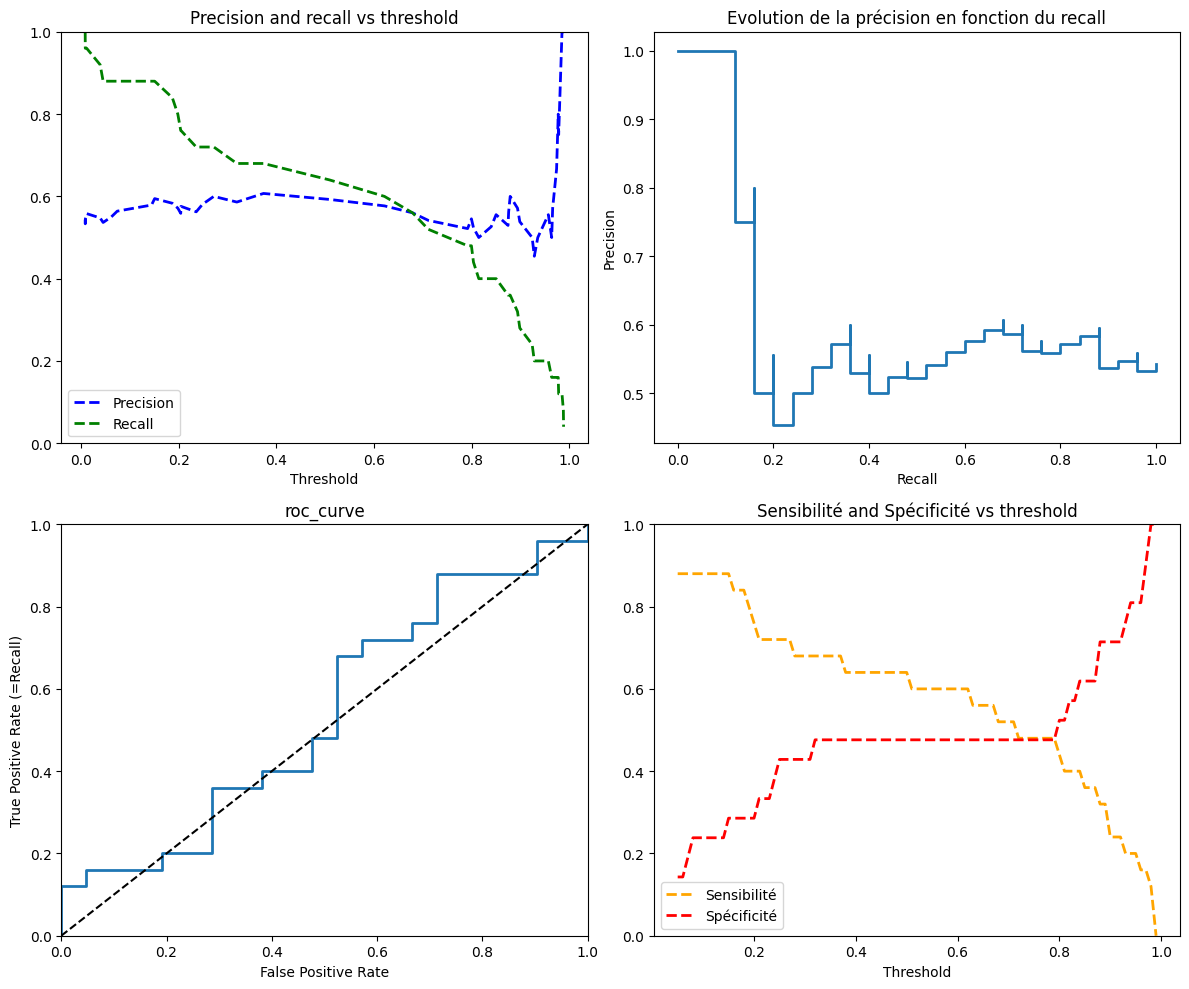

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.94
Sensibilité : 0.2
Spécificité : 0.8095238095238095


In [29]:
tree_BL = XGBClassifier(random_state=seed)
tree_BL.fit(X_train_nlp_features, y_train)
pred_BL = tree_BL.predict(X_test_nlp_features)
model_to_plot(tree_BL, X_test_nlp_features, y_test)
resultat_BL = pd.DataFrame(pd.Series(scores(y_test, pred_BL)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_BL.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_BL.loc['specificité','XGB_BL_sensi'])
dict_ = from_model_to_bst_trhld(tree_BL, X_test_nlp_features, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_['best_threshold'])
print('Sensibilité :', dict_['scores']['sensibilite'])
print('Spécificité :', dict_['scores']['specificité'])

--> Non

### Garder infos démographiques mais pas les evaluations

In [30]:
X_train_without_eva = X_train.copy()
X_test_without_eva = X_test.copy()

for col in X_train_without_eva.columns:
    if 'eva' in col:
        X_train_without_eva.drop(col, axis=1, inplace=True)
        X_test_without_eva.drop(col, axis=1, inplace=True)

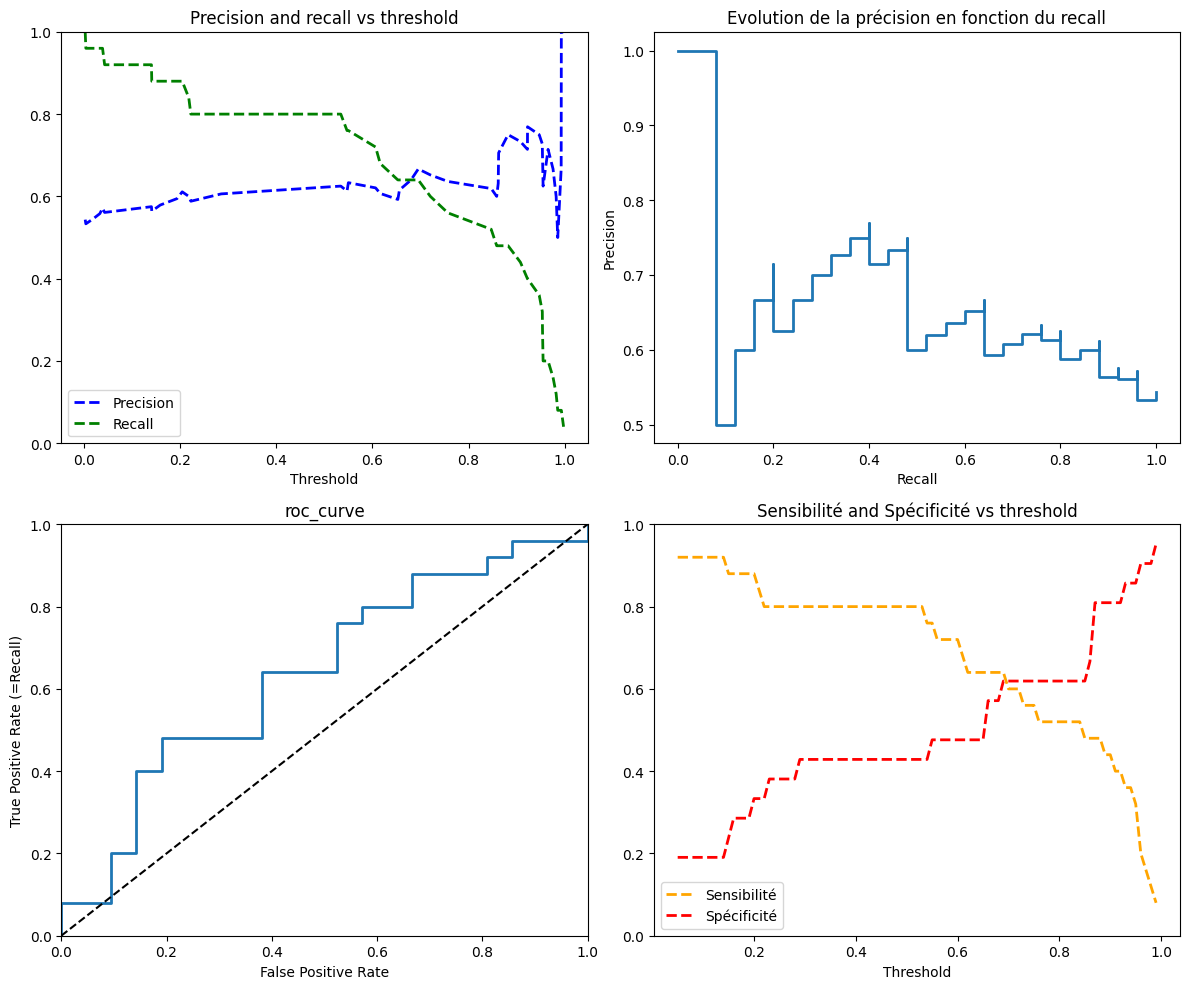

threshold = 0,5
Sensibilité :  0.8
Spécificité :  0.42857142857142855
_________________________________________________________
Best threshold : 0.87
Sensibilité : 0.48
Spécificité : 0.8095238095238095


In [31]:
tree_BL = XGBClassifier(random_state=seed)
tree_BL.fit(X_train_without_eva, y_train)
pred_BL = tree_BL.predict(X_test_without_eva)
model_to_plot(tree_BL, X_test_without_eva, y_test)
resultat_BL = pd.DataFrame(pd.Series(scores(y_test, pred_BL)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_BL.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_BL.loc['specificité','XGB_BL_sensi'])
dict_ = from_model_to_bst_trhld(tree_BL, X_test_without_eva, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_['best_threshold'])
print('Sensibilité :', dict_['scores']['sensibilite'])
print('Spécificité :', dict_['scores']['specificité'])

--> Sans features d'evaluation encore une bonne performance

### Modèle avec que les infos démographiques

In [32]:
X_train_only_demographic = X_train[['age', 'imc', 'g']].copy()
X_test_only_demographic = X_test[['age', 'imc', 'g']].copy()

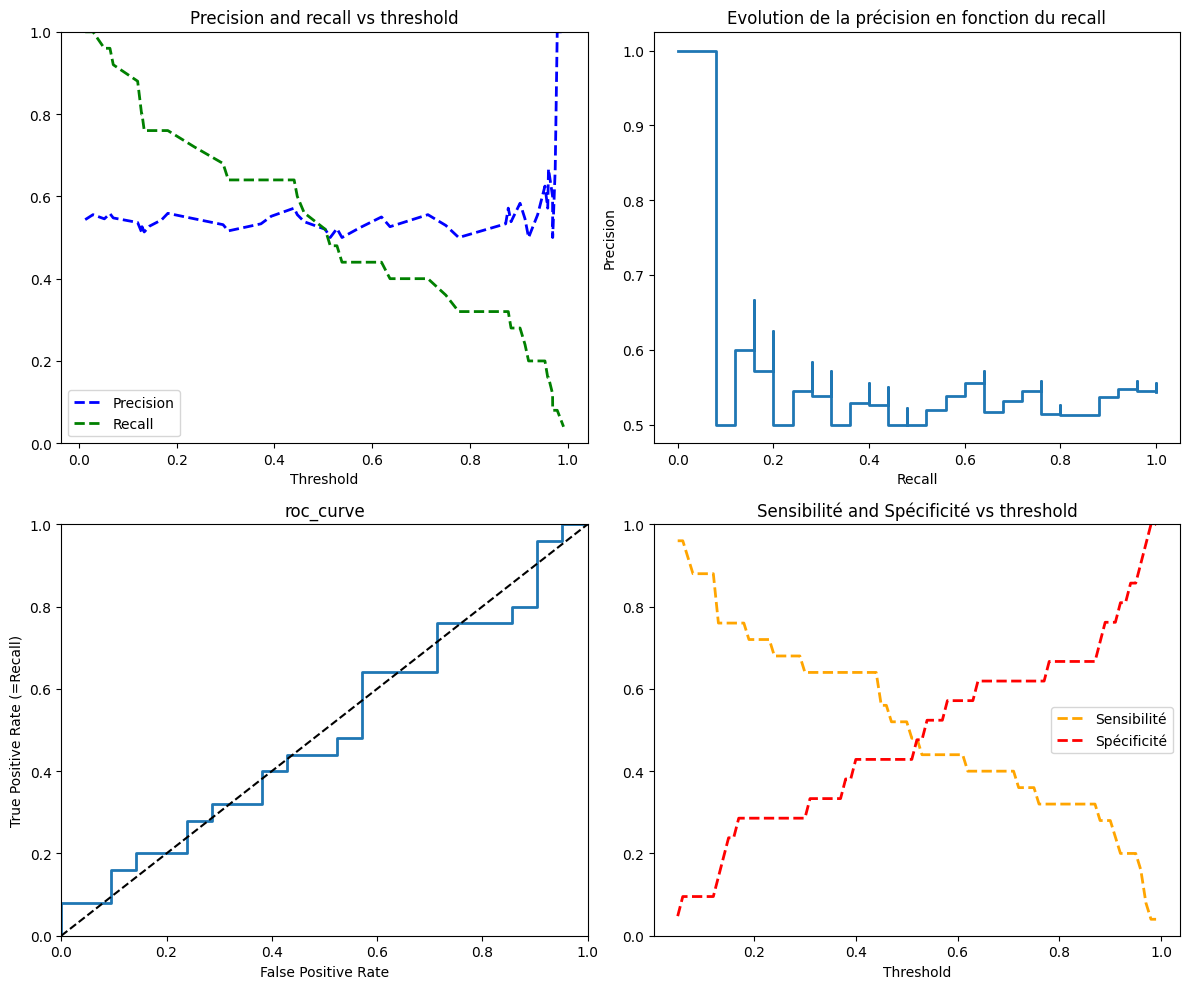

threshold = 0,5
Sensibilité :  0.52
Spécificité :  0.42857142857142855
_________________________________________________________
Best threshold : 0.94
Sensibilité : 0.2
Spécificité : 0.8571428571428571


In [33]:
tree_BL = XGBClassifier(random_state=seed)
tree_BL.fit(X_train_only_demographic, y_train)
pred_BL = tree_BL.predict(X_test_only_demographic)
model_to_plot(tree_BL, X_test_only_demographic, y_test)
resultat_BL = pd.DataFrame(pd.Series(scores(y_test, pred_BL)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_BL.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_BL.loc['specificité','XGB_BL_sensi'])
dict_ = from_model_to_bst_trhld(tree_BL, X_test_only_demographic, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_['best_threshold'])
print('Sensibilité :', dict_['scores']['sensibilite'])
print('Spécificité :', dict_['scores']['specificité'])

--> Symptômes sont quand-même utiles pour la prédiction

### Modèle avec que les infos démographiques +  eva

In [34]:
X_train_only_demographic_eva = X_train[['age', 'imc', 'g','sf.dsp.eva', 'sf.dsm.eva']].copy()
X_test_only_demographic_eva = X_test[['age', 'imc', 'g', 'sf.dsp.eva', 'sf.dsm.eva']].copy()

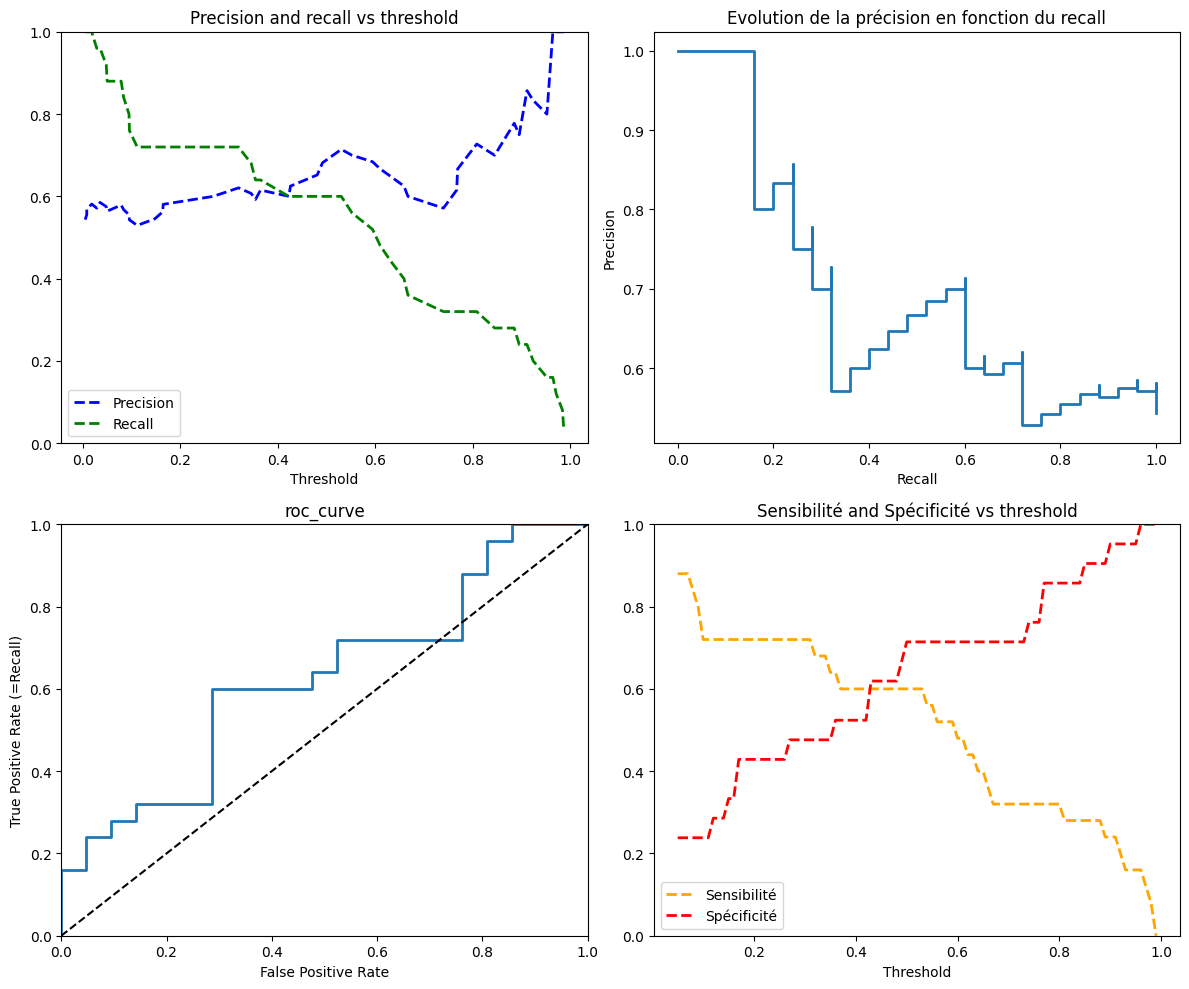

threshold = 0,5
Sensibilité :  0.6
Spécificité :  0.7142857142857143
_________________________________________________________
Best threshold : 0.77
Sensibilité : 0.32
Spécificité : 0.8571428571428571


In [35]:
tree_BL = XGBClassifier(random_state=seed)
tree_BL.fit(X_train_only_demographic_eva, y_train)
pred_BL = tree_BL.predict(X_test_only_demographic_eva)
model_to_plot(tree_BL, X_test_only_demographic_eva, y_test)
resultat_BL = pd.DataFrame(pd.Series(scores(y_test, pred_BL)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_BL.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_BL.loc['specificité','XGB_BL_sensi'])
dict_ = from_model_to_bst_trhld(tree_BL, X_test_only_demographic_eva, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_['best_threshold'])
print('Sensibilité :', dict_['scores']['sensibilite'])
print('Spécificité :', dict_['scores']['specificité'])

--> Symptômes sont quand-même utiles pour la prédiction

In [36]:
features_importances_symptoms = xgb_fea_imp.loc[~xgb_fea_imp['feature'].isin(features_to_drop_for_nlp)]
features_importances_symptoms

,feature,importance
3,atcd.endo,23.0
42,irm.lusg,22.0
25,tv.douloureux,18.0
16,sf.dig.diarrhee,16.0
48,irm.externe,16.0
23,ef.hormone.dpc,15.0
35,echo.lusd,15.0
36,echo.lusg,15.0
21,effet.hormone,14.0
9,atcd.absenteisme,13.0


### Explorer performance du modèle en fonction de quels symptômes sont inclus

In [37]:
cutoff_feature_importance = 2     # Symptômes avec feature importance en dessous sont rejetés
include_demographic = True
include_eva = False

important_symptoms = list(features_importances_symptoms.loc[features_importances_symptoms.importance >= cutoff_feature_importance]['feature'].values)

features_subset = important_symptoms
if include_demographic:
    features_subset = ['age', 'imc', 'g'] + features_subset
if include_eva:
    features_subset = ['sf.dsp.eva', 'sf.dsm.eva'] + features_subset
X_train_feature_subset = X_train[features_subset].copy()
X_test_feature_subset = X_test[features_subset].copy()

In [38]:
tree_BL = XGBClassifier(random_state=seed)
tree_BL.fit(X_train_feature_subset, y_train)
pred_BL = tree_BL.predict(X_test_feature_subset)
#model_to_plot(tree_BL, X_test_feature_subset, y_test)
resultat_BL = pd.DataFrame(pd.Series(scores(y_test, pred_BL)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_BL.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_BL.loc['specificité','XGB_BL_sensi'])
dict_ = from_model_to_bst_trhld(tree_BL, X_test_feature_subset, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_['best_threshold'])
print('Sensibilité :', dict_['scores']['sensibilite'])
print('Spécificité :', dict_['scores']['specificité'])

threshold = 0,5
Sensibilité :  0.72
Spécificité :  0.5238095238095238
_________________________________________________________
Best threshold : 0.84
Sensibilité : 0.48
Spécificité : 0.8095238095238095


#### Systematically change the feature importance cutoff

In [39]:
feature_importance_cutoffs = list(range(round(np.floor(np.min(features_importances_symptoms['importance']))), round(np.ceil(np.max(features_importances_symptoms['importance'])))))

In [40]:
nsymptoms = []
best_thresholds = []
sensitivities = []
specificities = []
features_included = []
for feat_imp_cuttoff in feature_importance_cutoffs:

    important_symptoms = list(features_importances_symptoms.loc[features_importances_symptoms.importance >= feat_imp_cuttoff]['feature'].values)
    nsymptoms = nsymptoms + [len(important_symptoms)]

    features_subset = important_symptoms
    if include_demographic:
        features_subset = ['age', 'imc', 'g'] + features_subset
    if include_eva:
        features_subset = ['sf.dsp.eva', 'sf.dsm.eva'] + features_subset
    X_train_feature_subset = X_train[features_subset].copy()
    X_test_feature_subset = X_test[features_subset].copy()
    
    tree_BL = XGBClassifier(random_state=seed)
    tree_BL.fit(X_train_feature_subset, y_train)
    pred_BL = tree_BL.predict(X_test_feature_subset)
    #model_to_plot(tree_BL, X_test_feature_subset, y_test)
    resultat_BL = pd.DataFrame(pd.Series(scores(y_test, pred_BL)), columns=['XGB_BL_sensi'])
    dict_ = from_model_to_bst_trhld(tree_BL, X_test_feature_subset, y_test)

    best_thresholds = best_thresholds + [dict_['best_threshold']]
    sensitivities = sensitivities + [dict_['scores']['sensibilite']]
    specificities = specificities + [dict_['scores']['specificité']]
results_by_feature_imp_cutoff = pd.DataFrame({'feature_importance_cutoffs': feature_importance_cutoffs, 'nsymptoms': nsymptoms, 'best_thresholds': best_thresholds, 'sensitivities': sensitivities, 'specificities': specificities})
results_by_feature_imp_cutoff.set_index('feature_importance_cutoffs', inplace=True)
results_by_feature_imp_cutoff

,nsymptoms,best_thresholds,sensitivities,specificities
feature_importance_cutoffs,,,,
1,48,0.84,0.52,0.809524
2,41,0.84,0.48,0.809524
3,36,0.89,0.44,0.809524
4,34,0.83,0.48,0.809524
5,30,0.90,0.40,0.857143
6,24,0.86,0.36,0.809524
7,21,0.81,0.44,0.809524
8,19,0.95,0.36,0.857143
9,19,0.95,0.36,0.857143


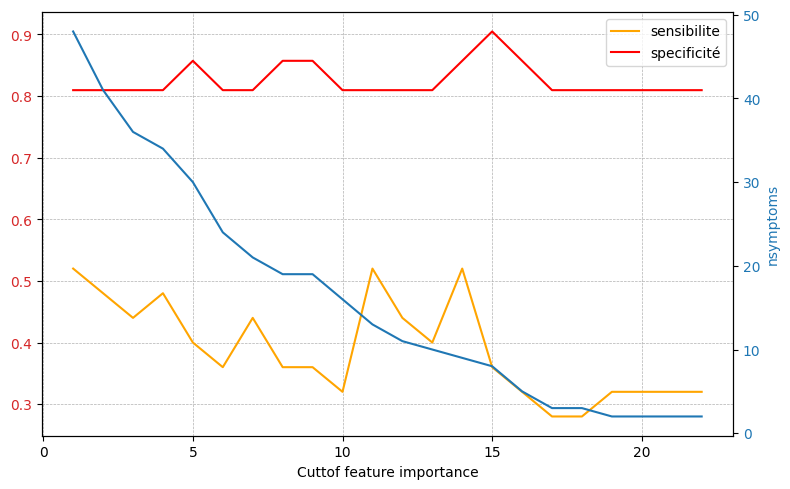

In [41]:
fig, ax1 = plt.subplots(figsize=(8, 5))

color = 'tab:red'
ax1.set_xlabel('Cuttof feature importance')
ax1.plot(feature_importance_cutoffs, sensitivities, 'orange')
ax1.plot(feature_importance_cutoffs, specificities, 'red')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(axis='both', which='both', linestyle = '--', linewidth = 0.5)
ax1.legend(['sensibilite', 'specificité'])

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('nsymptoms', color=color)  # we already handled the x-label with ax1
ax2.plot(feature_importance_cutoffs, nsymptoms, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [42]:
cutoff_feature_importance = 14
important_symptoms = list(features_importances_symptoms.loc[features_importances_symptoms.importance >= cutoff_feature_importance]['feature'].values)
print(f'Included symptoms with a cutoff of {cutoff_feature_importance}:')
print(important_symptoms)

Included symptoms with a cutoff of 14:
['atcd.endo', 'irm.lusg', 'tv.douloureux', 'sf.dig.diarrhee', 'irm.externe', 'ef.hormone.dpc', 'echo.lusd', 'echo.lusg', 'effet.hormone']


# Conclusion:

Il est possible d'obtenir une specificité autour de 0.8 et une sensitivité autour de 0.5 en réduisant le nombre de symptômes pris comme features à 9. Voici les 9 symptômes les plus importants:

['atcd.endo', 'irm.lusg', 'tv.douloureux', 'irm.externe', 'sf.dig.diarrhee', 'echo.lusg', 'echo.lusd', 'ef.hormone.dpc', 'effet.hormone']

Il est nécessaire d'avoir *au minimum* aussi l'information d'age, d'imc et parité, et *dans l'idéal* aussi les evalutations.